In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 10

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[md['notebook_name']=='Sherbrooke_RepCodes_jobs']

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
4246,2024-03-23 09:24:23.431000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqz93dxs9z7g008dny3g,"[Subset 52, 10 rounds, 0 log, xbasis=False]",1.0,6525.0,NaN,JobStatus.DONE,2024-03-23 10:20:19.544059+01:00,RepetitionCodeCircuit,52,10,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."
4245,2024-03-23 09:24:20.868000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqz93d5czq6g0081h1vg,"[Subset 52, 10 rounds, 0 log, xbasis=False]",1.0,6525.0,NaN,JobStatus.DONE,2024-03-23 10:19:41.529823+01:00,RepetitionCodeCircuit,52,10,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."


In [3]:
from result_saver import SaverProvider

provider = SaverProvider()
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 10:20:19.544059+01:00


In [4]:
from soft_info import inv_qubit_mapping, get_repcode_IQ_map

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

In [5]:
from Scratch import load_calibration_memory

all_memories_PS, _, msmt_err_dict = load_calibration_memory(provider, tobecalib_job=job_id, post_process=True, double_msmt=True)

Specified job execution date: 2024-03-23 10:20:19.544059+01:00
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 09:21:22.889460+00:00.


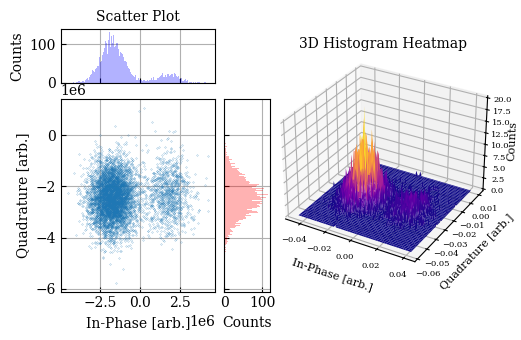

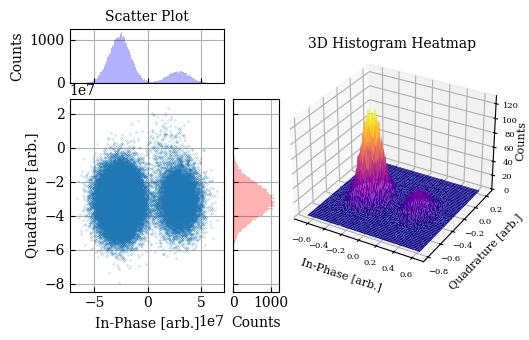

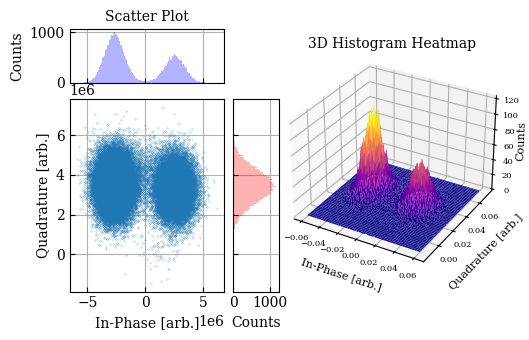

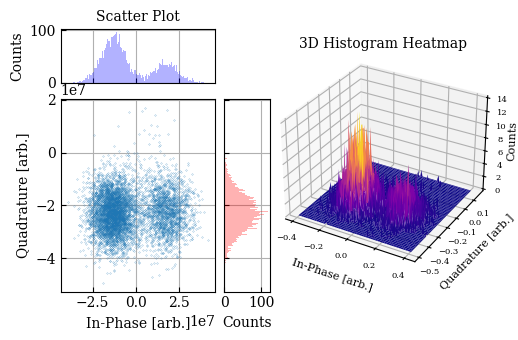

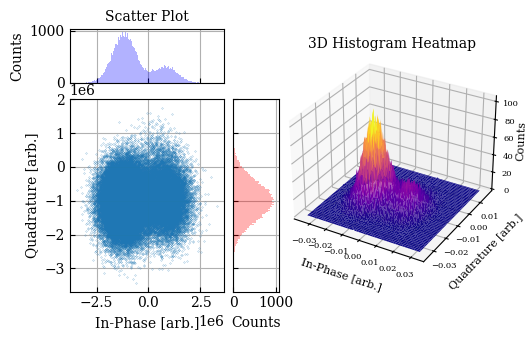

In [6]:
from soft_info import plot_IQ_data

for qubit in range(12, 20):
    cols = inverted_q_map.get(qubit, [])
    if len(cols) == 0:
        continue
    plot_IQ_data(memory[:, cols])

# RepCode data pipeline

Qubit 27
AIC relative difference above: 3.1523041070860236e-07, below: 1.03383487349728e-06
Qubit 44
Qubit 61
Qubit 69
Qubit 74
Qubit 80
Qubit 103
Qubit 107


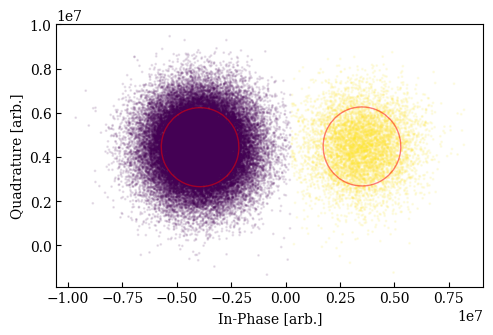

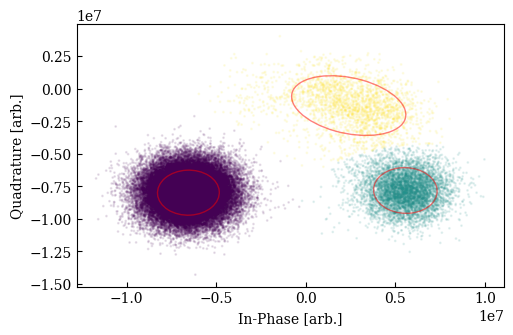

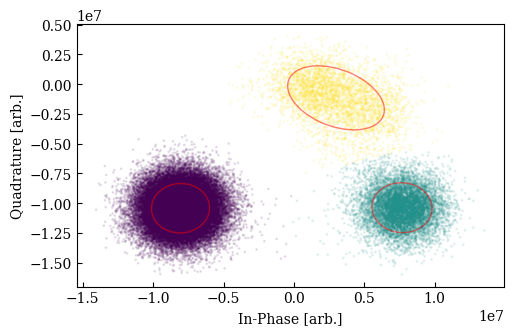

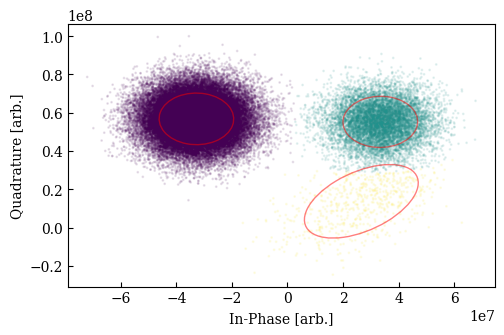

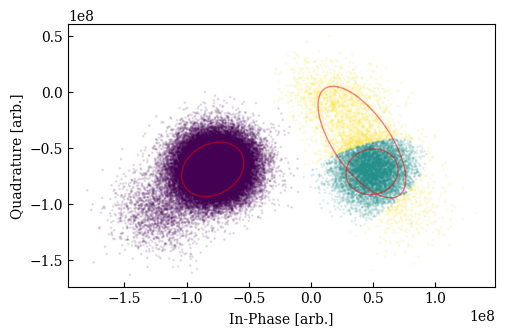

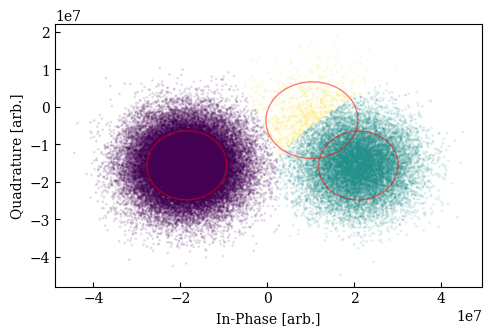

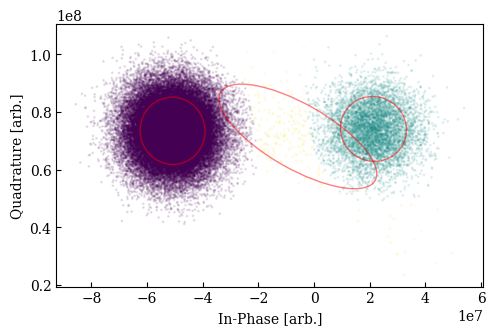

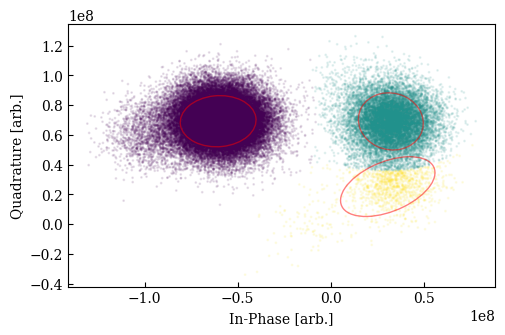

In [8]:
from soft_info import process_gmm_data, fit_gmm_0_calib, get_gmm_RepCodeData, plot_RepCode_gmm
import matplotlib.pyplot as plt



# for qubit in range(65):
for qubit in [27, 44, 61, 69, 74, 80, 103, 107]:
    cols = inverted_q_map.get(qubit, [])
    if len(cols) < 5:
        continue
    print(f"Qubit {qubit}")
    IQ_data = memory[:, cols].flatten()
    mmr_0 = all_memories_PS[qubit]['mmr_0']

    IQ_data_proc, mmr_0_proc, scaler = process_gmm_data(IQ_data, mmr_0)

    gmm_0 = fit_gmm_0_calib(mmr_0_proc)
    gmm = get_gmm_RepCodeData(IQ_data_proc, gmm_0)
    plot = plot_RepCode_gmm(IQ_data_proc, gmm)


Qubit 27
AIC relative difference above: 3.1523041070860236e-07, below: 1.03383487349728e-06
Qubit 44
Qubit 61
Qubit 69
Qubit 74
Qubit 80
Qubit 103
Qubit 107


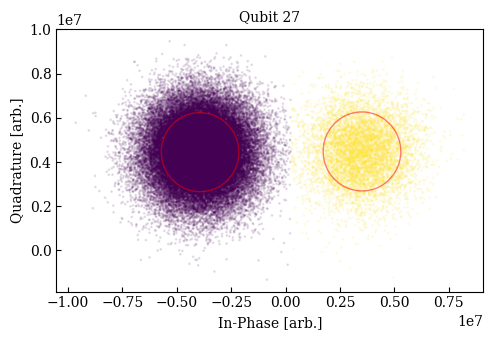

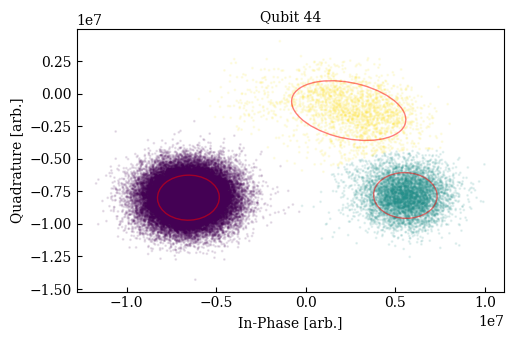

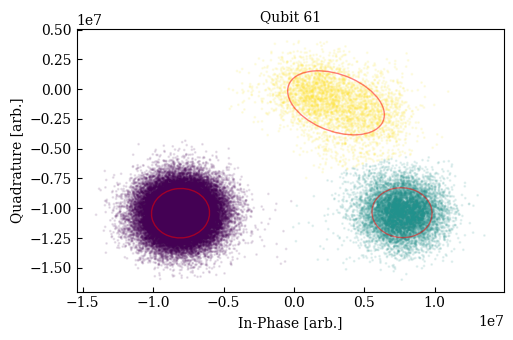

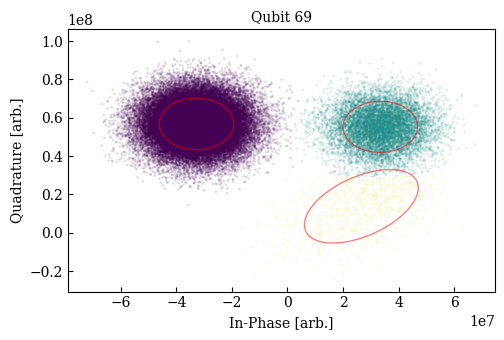

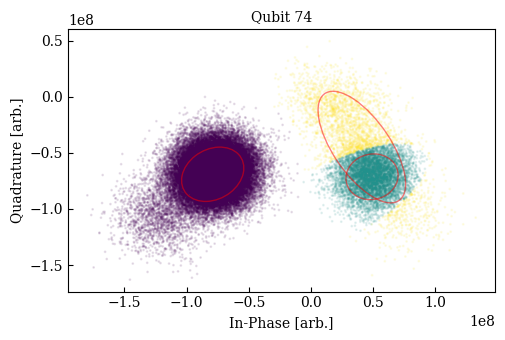

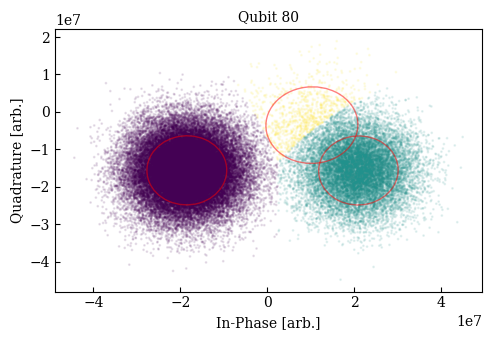

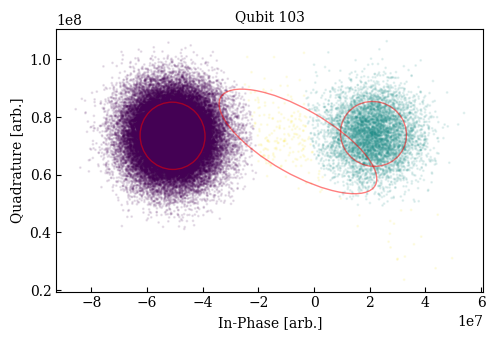

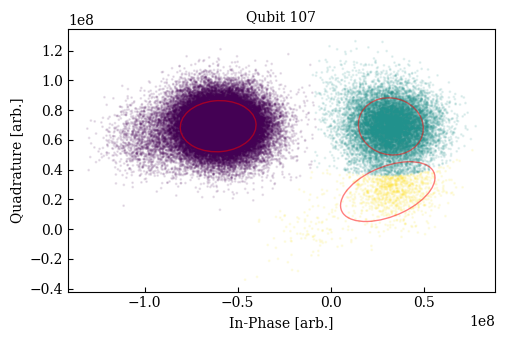

In [9]:
# from soft_info import (fit_calib_data, plot_gmm_classifications_and_ellipses, 
#                        combine_gmms_equally, plot_gmm_classifications_and_ellipses_comb, 
#                        fit_RepCode_data, plot_IQ_data, fit_RepCode_data_2, fit_gmm_0_calib)
# import matplotlib.pyplot as plt 
# from sklearn.preprocessing import StandardScaler


# # for qubit in range(65):
# for qubit in [27, 44, 61, 69, 74, 80, 103, 107]:
#     try:
#         cols = inverted_q_map[qubit]
#     except:
#         print(f"Qubit {qubit} not in the layout")
#         continue

#     if len(cols) < 5: 
#         continue
#     print(f"Qubit {qubit}")
#     IQ_data = memory[:, cols].flatten()

#     gmm_0 = fit_gmm_0_calib(all_memories_PS[qubit]['mmr_0'])
#     gmm = fit_RepCode_data_2(IQ_data, gmm_0, None)
#     plot = plot_gmm_classifications_and_ellipses_comb(IQ_data, gmm, title=f"Qubit {qubit}")


In [ ]:
from soft_info import (fit_calib_data, plot_gmm_classifications_and_ellipses, 
                       combine_gmms_equally, plot_gmm_classifications_and_ellipses_comb, 
                       fit_RepCode_data, plot_IQ_data, fit_RepCode_data_2)

qubit = 14
cols = inverted_q_map[qubit]
IQ_data = memory[:, cols].flatten()

gmm_0, gmm_1 = fit_calib_data(all_memories_PS[qubit]['mmr_0'], all_memories_PS[qubit]['mmr_1'])
# gmm_RepCode = fit_RepCode_data(IQ_data, gmm_0, gmm_1)
# gmm_RepCode = fit_RepCode_data_2(IQ_data, gmm_0, gmm_1)
gmm_2, gmm_3 = fit_RepCode_data_2(IQ_data, gmm_0, gmm_1)

plot = plot_gmm_classifications_and_ellipses_comb(IQ_data, gmm_2, title=f"Qubit {qubit}")
plot = plot_gmm_classifications_and_ellipses_comb(IQ_data, gmm_3, title=f"Qubit {qubit}")
plot2 = plot_IQ_data(IQ_data)

# Calib data fit pipeline

In [ ]:
from soft_info import fit_calib_data, plot_gmm_classifications_and_ellipses, combine_gmms_equally, plot_gmm_classifications_and_ellipses_comb

qubit = 69

gmm_0, gmm_1 = fit_calib_data(all_memories_PS[qubit]['mmr_0'], all_memories_PS[qubit]['mmr_1'])
gmm_combined = combine_gmms_equally(gmm_0, gmm_1)

combined_IQ_data = np.hstack([all_memories_PS[qubit]['mmr_0'], all_memories_PS[qubit]['mmr_1']])
plot1 = plot_gmm_classifications_and_ellipses_comb(combined_IQ_data, gmm_combined)
plot2 = plot_gmm_classifications_and_ellipses(combined_IQ_data, gmm_0, gmm_1)

In [ ]:
for qubit in range(127):
    if qubit > 20:
        break
    gmm_0, gmm_1 = fit_calib_data(all_memories_PS[qubit]['mmr_0'], all_memories_PS[qubit]['mmr_1'])
    if gmm_1.n_components == 2: 
        gmm_combined = combine_gmms_equally(gmm_0, gmm_1)

        combined_IQ_data = np.hstack([all_memories_PS[qubit]['mmr_0'], all_memories_PS[qubit]['mmr_1']])
        plot1 = plot_gmm_classifications_and_ellipses_comb(combined_IQ_data, gmm_combined, title=f"Qubit {qubit}")
        plot2 = plot_gmm_classifications_and_ellipses(combined_IQ_data, gmm_0, gmm_1)